## Convolutional Neural Network



In this notebook you will learn to distinguish dogs from cats!

Data:
https://drive.google.com/drive/folders/1bkcr55sW6BrcgKVPEGTb3vvhpnrklKKq?usp=sharing

Fill in cells below and fit neural networks for solving the binary classification task.

**Requirement**
- Python, Pytorch (Must), and all other necessary libraries
- **Just don't cheat, Thanks!**
- Sample output is to help you understand the task, and get an idea of what you have to do
- Dur date is Nov 10, 11:59pm. You ONLY need to submit this notebook. Include instructions to run your code.

## Task 1(25 points):

1. Build and fit CNN with 3 convolutional layers for binary classification
2. Evaluate accuracy on test data
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)

First, let's load all the necessary functions:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Cats_and_Dogs/

Mounted at /content/drive

/content/drive/My Drive/Cats_and_Dogs


In [ ]:
# Research on how to load google drive files into colab if you are using colab

In [ ]:
!ls train/dogs/ | wc -l

ls: cannot access 'train/dogs/': No such file or directory
0


The images collected for training and testing the deep learning model must be prepared: split the entire set into a training, validation and test sample, observing the balancing of classes (with binary classification they should be approximately equal in all three samples).

This has _already_ been done: in the Cats_and_Dogs directory there are three subdirectories: train, test and val - training, test and validation samples, respectively.

In [ ]:

# Initialize the folders with train, test and validation datasets (in "/My Drive/..." or from your local repository where you have downloaded data):
import torch.nn as nn
import torch.nn.functional as F
import torch

train = '/kaggle/input/cats-and-dogs/Cats_and_Dogs/train'
val = '/kaggle/input/cats-and-dogs/Cats_and_Dogs/val'
test = '/kaggle/input/cats-and-dogs/Cats_and_Dogs/test'

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3 # you can try different sizes

# input shape
input_shape = (img_width, img_height, 3)
# position matters!
# Number_of_channels can be at the first or the last position
# in our case - "channels last"

# minibatch size
batch_size = 4
# train set size
nb_train_samples = 20000
# validation set size
nb_validation_samples = 2490
# test set size
nb_test_samples = 2500

## Prepare the data.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

resize = transforms.Resize(size=(img_height, img_width))
trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])
testTransforms = transforms.Compose([resize, transforms.ToTensor()])

train_path = '/kaggle/input/cats-and-dogs/Cats_and_Dogs/train'
val_path = '/kaggle/input/cats-and-dogs/Cats_and_Dogs/val'
test_path = '/kaggle/input/cats-and-dogs/Cats_and_Dogs/test'

train_data = ImageFolder(train_path, transform=trainTransforms)
val_data = ImageFolder(val_path, transform=valTransforms)
test_data = ImageFolder(test_path, transform=testTransforms)
# Setup the batch size hyperparameter
BATCH_SIZE = batch_size

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(val_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader,val_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fcc29b28a00>, <torch.utils.data.dataloader.DataLoader object at 0x7fcc29c35ea0>, <torch.utils.data.dataloader.DataLoader object at 0x7fcc29b28a90>)
Length of train dataloader: 5000 batches of 4
Length of val dataloader: 623 batches of 4
Length of test dataloader: 625 batches of 4


Set the network architecture by sequentially adding layers to it:
1. A convolutional layer with 16 neurons, filter size 3x3. Activation function - 'relu'
2. MaxPooling layer with filter size 2x2.
3. A convolutional layer with 32 neurons, filter size 3x3. Activation function - 'relu'
4. MaxPooling layer with filter size 2x2.
5. A convolutional layer with 64 neurons, filter size 3x3. Activation function - 'relu'
6. MaxPooling layer with filter size 2x2.
7. flatten, which makes a one-dimensional vector of the resulting feature maps.
8. A fully connected layer with 64 neurons. Activation function - 'relu'
9. Use Dropout (0.5) which excludes the edge from the current layer in the computational graph with a 50% probability to avoid overfitting.
10. A fully connected layer with 1 neuron. Activation function - 'sigmoid', because binary classification model.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class CatsVsDogsModel(nn.Module):
    def __init__(self):
        super(CatsVsDogsModel, self).__init__()

        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(64 * 17 * 17, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [ ]:
import torch.optim as optim
from torch.autograd import Variable

model = CatsVsDogsModel()
model = model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


train_loss = []
train_acc = []
validation_loss = []
validation_accuracy = []

def train(no_of_epochs):
  for epoch in range(no_of_epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      running_corrects = 0
      count = 0

      model.train()
      for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
          # print(inputs)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
          # labels = labels.squeeze()
          # print(inputs)
          # print(labels)

          # zero the parameter gradients
        optimizer.zero_grad()

          # forward + backward + optimize
          # model.train()
        outputs = model(inputs)
          # TODO: calculate the preds
        binary_predictions = (outputs > 0.5).float()
        preds = binary_predictions.squeeze()
        loss = criterion(outputs.squeeze(), labels.float())
          # print(preds.float())
          # print(labels)
          # print(loss)
        loss.backward()
        optimizer.step()

          # print statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)
        # if i % 50 == 49: # print every 2000 mini-batches
        #   # print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}')
        #   running_counts = 0
        #   running_loss = 0.0
        #   count = 0
      running_loss = running_loss/len(train_dataloader)
      train_accuracy = running_corrects/count
#       print("Training Data:")
#       print(f"Epoch [{epoch+1}/{no_of_epochs}] : Train Loss: {running_loss:.4f},  Train Accuracy: {train_accuracy:.4f}")
#       train_loss.append(running_loss)
#       train_acc.append(train_accuracy)

      #validation
      model.eval()
      running_loss_val = 0.0
      running_corrects_val = 0
      count_val = 0

      with torch.no_grad():
            for i, data in enumerate(val_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                # print(inputs)
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = model(inputs)
                # TODO: calculate the preds
                binary_predictions = (outputs > 0.5).float()
                preds = binary_predictions.squeeze()
                loss = criterion(outputs.squeeze(), labels.float())

                # print statistics
                running_loss_val += loss.item()
                running_corrects_val += torch.sum(preds == labels.data)
                count_val += len(preds)
                # if i % 50 == 49:  # print every 2000 mini-batches
                #   # print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}')
                #   running_counts_val = 0
                #   running_loss_val = 0.0
                #   count_val = 0
      running_loss_val = running_loss_val/len(val_dataloader)
      val_accuracy = running_corrects_val/count_val
#       print('Validation Data:')
      print(f"Epoch [{epoch+1}/{no_of_epochs}]: Train Loss: {running_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Loss: {running_loss_val:.4f}, Val Accuracy: {val_accuracy:.4f}")
      train_loss.append(running_loss)
      train_acc.append(train_accuracy)
      validation_loss.append(running_loss_val)
      validation_accuracy.append(val_accuracy)

#         train_loss.append(running_loss)
#         train_acc.append(train_accuracy)

In [ ]:
def test(model):
  model.eval()
    # running_loss = 0
  running_corrects_test = 0
  count_test = 0

  with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
        # print(inputs)
      inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      outputs = model(inputs)
        # TODO: calculate the preds
      binary_predictions = (outputs > 0.5).float()
      preds = binary_predictions.squeeze()

        # print statistics
      running_corrects_test += torch.sum(preds == labels.data)
      count_test += len(preds)
        # if i % 50 == 49:  # print every 2000 mini-batches
        #   # print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}')
        #   running_counts_val = 0
        #   running_loss_val = 0.0
        #   count_val = 0
  test_accuracy = running_corrects_test/count_test
  print('Testing Data:')
  print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
train(10)

Epoch [1/10]: Train Loss: 0.6922,  Train Accuracy: 0.5174, Val Loss: 0.6875, Val Accuracy: 0.5618
Epoch [2/10]: Train Loss: 0.6733,  Train Accuracy: 0.5841, Val Loss: 0.6394, Val Accuracy: 0.6462
Epoch [3/10]: Train Loss: 0.6093,  Train Accuracy: 0.6732, Val Loss: 0.5700, Val Accuracy: 0.7076
Epoch [4/10]: Train Loss: 0.5621,  Train Accuracy: 0.7100, Val Loss: 0.5517, Val Accuracy: 0.7120
Epoch [5/10]: Train Loss: 0.5140,  Train Accuracy: 0.7473, Val Loss: 0.4928, Val Accuracy: 0.7639
Epoch [6/10]: Train Loss: 0.4727,  Train Accuracy: 0.7791, Val Loss: 0.4841, Val Accuracy: 0.7751
Epoch [7/10]: Train Loss: 0.4309,  Train Accuracy: 0.7993, Val Loss: 0.4420, Val Accuracy: 0.7924
Epoch [8/10]: Train Loss: 0.3918,  Train Accuracy: 0.8258, Val Loss: 0.4547, Val Accuracy: 0.7799
Epoch [9/10]: Train Loss: 0.3505,  Train Accuracy: 0.8457, Val Loss: 0.4378, Val Accuracy: 0.7944
Epoch [10/10]: Train Loss: 0.3110,  Train Accuracy: 0.8656, Val Loss: 0.4638, Val Accuracy: 0.7908


In [ ]:
test(model)

Testing Data:
Test Accuracy: 0.7940


In [ ]:
train(15)

Epoch [1/15]: Train Loss: 0.2646,  Train Accuracy: 0.8884, Val Loss: 0.4758, Val Accuracy: 0.8000
Epoch [2/15]: Train Loss: 0.2307,  Train Accuracy: 0.9072, Val Loss: 0.4822, Val Accuracy: 0.8056
Epoch [3/15]: Train Loss: 0.1948,  Train Accuracy: 0.9190, Val Loss: 0.6290, Val Accuracy: 0.8116
Epoch [4/15]: Train Loss: 0.1684,  Train Accuracy: 0.9319, Val Loss: 0.6223, Val Accuracy: 0.7880
Epoch [5/15]: Train Loss: 0.1554,  Train Accuracy: 0.9408, Val Loss: 0.6042, Val Accuracy: 0.8137
Epoch [6/15]: Train Loss: 0.1348,  Train Accuracy: 0.9487, Val Loss: 0.5925, Val Accuracy: 0.8004
Epoch [7/15]: Train Loss: 0.1226,  Train Accuracy: 0.9517, Val Loss: 0.7540, Val Accuracy: 0.8076
Epoch [8/15]: Train Loss: 0.1167,  Train Accuracy: 0.9560, Val Loss: 0.7078, Val Accuracy: 0.8000
Epoch [9/15]: Train Loss: 0.1075,  Train Accuracy: 0.9603, Val Loss: 0.8142, Val Accuracy: 0.8116
Epoch [10/15]: Train Loss: 0.0969,  Train Accuracy: 0.9624, Val Loss: 1.0591, Val Accuracy: 0.8129
Epoch [11/15]: Trai

In [ ]:
test(model)

Testing Data:
Test Accuracy: 0.8112


In [ ]:
train(20)

Epoch [1/20]: Train Loss: 0.0652,  Train Accuracy: 0.9748, Val Loss: 1.1599, Val Accuracy: 0.8129
Epoch [2/20]: Train Loss: 0.0645,  Train Accuracy: 0.9765, Val Loss: 1.2192, Val Accuracy: 0.8189
Epoch [3/20]: Train Loss: 0.0594,  Train Accuracy: 0.9776, Val Loss: 0.9443, Val Accuracy: 0.8201
Epoch [4/20]: Train Loss: 0.0571,  Train Accuracy: 0.9788, Val Loss: 0.9480, Val Accuracy: 0.8149
Epoch [5/20]: Train Loss: 0.0598,  Train Accuracy: 0.9785, Val Loss: 1.5094, Val Accuracy: 0.8108
Epoch [6/20]: Train Loss: 0.0572,  Train Accuracy: 0.9794, Val Loss: 1.2777, Val Accuracy: 0.8149
Epoch [7/20]: Train Loss: 0.0528,  Train Accuracy: 0.9804, Val Loss: 1.1523, Val Accuracy: 0.8137
Epoch [8/20]: Train Loss: 0.0515,  Train Accuracy: 0.9798, Val Loss: 1.2667, Val Accuracy: 0.8185
Epoch [9/20]: Train Loss: 0.0492,  Train Accuracy: 0.9815, Val Loss: 1.0175, Val Accuracy: 0.8161
Epoch [10/20]: Train Loss: 0.0514,  Train Accuracy: 0.9805, Val Loss: 1.6441, Val Accuracy: 0.8173
Epoch [11/20]: Trai

In [ ]:
test(model)

Testing Data:
Test Accuracy: 0.8264


In [ ]:
model_path_1 = 'model1.pt'
torch.save(model.state_dict(), model_path_1)

In [ ]:
model_path_2 = 'model1.pickle'
torch.save(model, model_path_2)

In [ ]:
train_loss
# train_acc

[0.6921621999502182,
 0.6732610396742821,
 0.6093140783309936,
 0.5620563604235649,
 0.5140221020594239,
 0.47274747511669996,
 0.4308978199440986,
 0.3917654971331358,
 0.350517538142344,
 0.3110243353294441,
 0.2646223811304284,
 0.23072694838149072,
 0.19484659209117816,
 0.16836408603480008,
 0.155360717223998,
 0.13477534194430185,
 0.12257692581772997,
 0.1166548205157549,
 0.10747830020907727,
 0.09685639952677216,
 0.08471899913833282,
 0.08022606914900776,
 0.08239826413716048,
 0.0766237410142573,
 0.07372245903096578,
 0.06521614875926982,
 0.0645421220411005,
 0.059365112060793784,
 0.057093196178807225,
 0.0597718835483741,
 0.05717724745466736,
 0.052836313112658774,
 0.05146767805314729,
 0.04918511955461247,
 0.05142091645308352,
 0.04904665282731596,
 0.04948409700703743,
 0.04192706383933342,
 0.046428009711303585,
 0.042586703070850086,
 0.038610108193764384,
 0.04071150310613012,
 0.030464780210222874,
 0.03902987672877295,
 0.03596898590071484]

Plot the graphs:

- Loss(Number of epochs)

- Accuracy(Number of epochs)

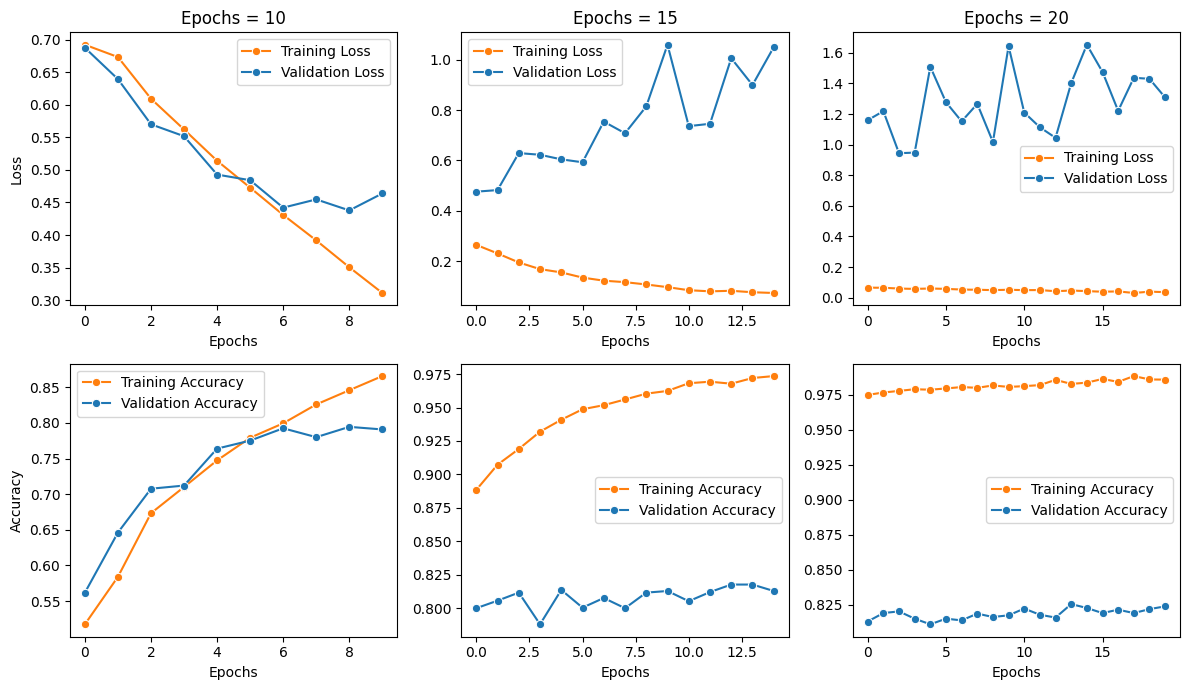

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the 6 subplots (replace with your own data)

train_acc_g = [acc.item() for acc in train_acc]
val_acc_g = [acc.item() for acc in validation_accuracy]


train_loss_1 = train_loss[0:10]
val_loss_1 = validation_loss[0:10]
train_loss_2 = train_loss[10:25]
val_loss_2 = validation_loss[10:25]
train_loss_3 = train_loss[25:45]
val_loss_3 = validation_loss[25:45]

train_acc_1 = train_acc_g[0:10]
val_acc_1 = val_acc_g[0:10]
train_acc_2 = train_acc_g[10:25]
val_acc_2 = val_acc_g[10:25]
train_acc_3 = train_acc_g[25:45]
val_acc_3 = val_acc_g[25:45]

# Create a 2x3 grid of subplots
fig, sub = plt.subplots(2, 3, figsize=(12, 7))

# Plot the data in each subplot using seaborn
sns.lineplot(train_loss_1, ax=sub[0, 0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss_1, ax=sub[0, 0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
sub[0, 0].set_title('Epochs = 10')
sub[0, 0].set_xlabel('Epochs')
sub[0, 0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_loss_2, ax=sub[0, 1],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss_2, ax=sub[0, 1], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
sub[0, 1].set_title('Epochs = 15')
sub[0, 1].set_xlabel('Epochs')
sub[0, 1].set_ylabel('')

# sns.lineplot(x=epochs, y=losses_3, ax=axes[0, 2])
sns.lineplot(train_loss_3, ax=sub[0, 2],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss_3, ax=sub[0, 2], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
sub[0, 2].set_title('Epochs = 20')
sub[0, 2].set_xlabel('Epochs')
sub[0, 2].set_ylabel('')

# sns.lineplot(x=epochs, y=losses_4, ax=axes[1, 0])
sns.lineplot(train_acc_1, ax=sub[1, 0],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc_1, ax=sub[1, 0], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
sub[1, 0].set_title('')
sub[1, 0].set_xlabel('Epochs')
sub[1, 0].set_ylabel('Accuracy')

# sns.lineplot(x=epochs, y=losses_5, ax=axes[1, 1])
sns.lineplot(train_acc_2, ax=sub[1, 1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc_2, ax=sub[1, 1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
sub[1, 1].set_title('')
sub[1, 1].set_xlabel('Epochs')
sub[1, 1].set_ylabel('')

# sns.lineplot(x=epochs, y=losses_6, ax=axes[1, 2])
sns.lineplot(train_acc_3, ax=sub[1, 2],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc_3, ax=sub[1, 2], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
sub[1, 2].set_title('')
sub[1, 2].set_xlabel('Epochs')
sub[1, 2].set_ylabel('')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Let's try to improve the quality of recognition, using the method of transfer lerning.

We will use weights of deep neural networks already trained on large dataset such as  ImageNet, and provide fine tuning of several additional dense layers on new data relevant to the current classification task. The more new images will differ from those on which the network has been trained, the more layers will need to be “retrained” in order to get good classification accuracy. The intuition here is that the model has already learned how to highlight the necessary features on the images in the large dataset, it only needs to be “tweaked” for a specific task.

## Task 2(25 points)

1. Build and fit Transfer Learning model using pre-trained VGG16-model weights.
2. Evaluate accuracy on test data for p.1 and p.2
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)
4. Check the performance of your model with the custom image of cat or dog (so the model will tell which class this image belongs to). Develop the function for the inference of the best algorithm.

In [ ]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# First, download the weights of the VGG16 network trained on the ImageNet dataset:
from torchsummary import summary
import torch.nn as nn
import torchvision.models as models

# Download the pre-trained VGG16 model

model_2 = models.vgg16(pretrained=True)
model_2 = model_2.cuda()
summary(model_2, (3, 224, 224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 299MB/s]  


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

We construct our model of "transfer learning" by adding two fully connected layers to VGG16

In [ ]:
# add layers to VGG16:
custom_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
#     nn.Linear(4096, 4096),
#     nn.ReLU(),
#     nn.Dropout(0.5),
    nn.Linear(4096, 1),
    nn.Sigmoid()
)

model_2.classifier = nn.Sequential(custom_layers)
model_2 = model_2.cuda()
summary(model_2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Implement the code to train the model
# Without using a GPU, learning 1 epoch of such a network will take about an hour. Plan your time =)
# If you have access to a GPU, you can try 10-12 epochs - the quality should increase even more.
import torch.optim as optim
from torch.autograd import Variable

model_2 = model_2.cuda()
criterion_2 = nn.BCELoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.0001, momentum=0.9)


train_loss_vgg = []
train_acc_vgg = []
validation_loss_vgg = []
validation_accuracy_vgg = []

def train_vgg(model,no_of_epochs):
  for epoch in range(no_of_epochs):  # loop over the dataset multiple times

      training_loss = 0.0
      running_corrects = 0
      count = 0

      model.train()
      for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer_2.zero_grad()
        outputs = model(inputs)
        binary_predictions = (outputs > 0.5).float()
        preds = binary_predictions.squeeze()
        loss = criterion_2(outputs.squeeze(), labels.float())
#         loss = criterion(outputs, labels)
        loss.backward()
        optimizer_2.step()

          # print statistics
        training_loss += loss.item()
#         binary_predictions = (outputs > 0.5).float()
#         preds = binary_predictions
        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)
        # if i % 50 == 49: # print every 2000 mini-batches
        #   # print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}')
        #   running_counts = 0
        #   running_loss = 0.0
        #   count = 0
      training_loss = training_loss/len(train_dataloader)
      train_accuracy = running_corrects/count

      model.eval()
      running_loss_val = 0.0
      running_corrects_val = 0
      count_val = 0

      with torch.no_grad():
            for i, data in enumerate(val_dataloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = model(inputs)
                binary_predictions = (outputs > 0.5).float()
                preds = binary_predictions.squeeze()
                loss = criterion_2(outputs.squeeze(), labels.float())

                running_loss_val += loss.item()
                running_corrects_val += torch.sum(preds == labels.data)
                count_val += len(preds)
                # if i % 50 == 49:  # print every 2000 mini-batches
                #   # print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}')
                #   running_counts_val = 0
                #   running_loss_val = 0.0
                #   count_val = 0
      running_loss_val = running_loss_val/len(val_dataloader)
      val_accuracy = running_corrects_val/count_val
#         print('Validation Data:')
#         print(f"Epoch [{epoch+1}/{no_of_epochs}]: Val Loss: {running_loss_val:.4f}, Val Accuracy: {val_accuracy:.4f}")

#         validation_loss_vgg.append(running_loss_val)
#         validation_accuracy_vgg.append(val_accuracy)
#       print("Training Data:")
      print(f"Epoch [{epoch+1}/{no_of_epochs}]: Train Loss: {training_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Loss: {running_loss_val:.4f}, Val Accuracy: {val_accuracy:.4f}")

      train_loss_vgg.append(training_loss)
      train_acc_vgg.append(train_accuracy)
      validation_loss_vgg.append(running_loss_val)
      validation_accuracy_vgg.append(val_accuracy)

In [ ]:
train_vgg(model_2, 10)

Epoch [1/10]: Train Loss: 0.0712,  Train Accuracy: 0.9713, Val Loss: 0.0474, Val Accuracy: 0.9867
Epoch [2/10]: Train Loss: 0.0282,  Train Accuracy: 0.9891, Val Loss: 0.0899, Val Accuracy: 0.9811
Epoch [3/10]: Train Loss: 0.0135,  Train Accuracy: 0.9953, Val Loss: 0.0951, Val Accuracy: 0.9839
Epoch [4/10]: Train Loss: 0.0073,  Train Accuracy: 0.9976, Val Loss: 0.0937, Val Accuracy: 0.9843
Epoch [5/10]: Train Loss: 0.0021,  Train Accuracy: 0.9995, Val Loss: 0.1018, Val Accuracy: 0.9851
Epoch [6/10]: Train Loss: 0.0041,  Train Accuracy: 0.9988, Val Loss: 0.0945, Val Accuracy: 0.9855
Epoch [7/10]: Train Loss: 0.0038,  Train Accuracy: 0.9987, Val Loss: 0.1026, Val Accuracy: 0.9847
Epoch [8/10]: Train Loss: 0.0037,  Train Accuracy: 0.9990, Val Loss: 0.1037, Val Accuracy: 0.9876
Epoch [9/10]: Train Loss: 0.0004,  Train Accuracy: 0.9999, Val Loss: 0.1130, Val Accuracy: 0.9847
Epoch [10/10]: Train Loss: 0.0003,  Train Accuracy: 0.9999, Val Loss: 0.1178, Val Accuracy: 0.9847


In [ ]:
test(model_2)

Testing Data:
Test Accuracy: 0.9824


In [ ]:
model_path_3 = 'model2.pt'
torch.save(model_2.state_dict(), model_path_3)

In [ ]:
model_path_4 = 'model2.pickle'
torch.save(model_2, model_path_4)

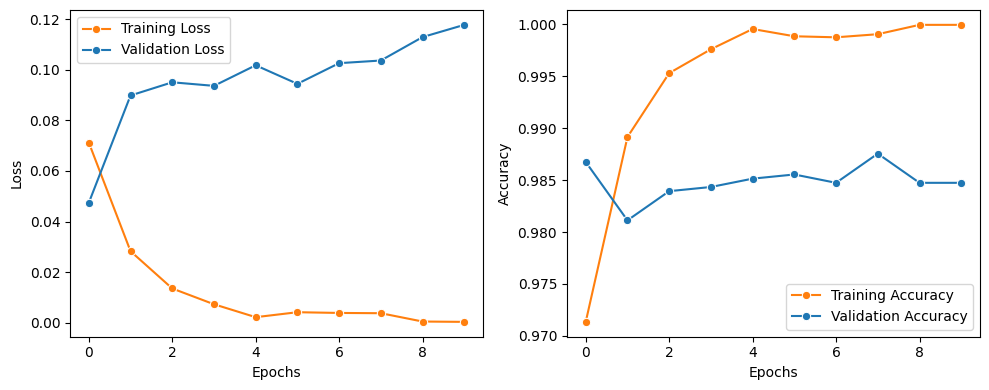

In [ ]:
vgg_train_loss = train_loss_vgg
vgg_val_loss = validation_loss_vgg

train_acc_gg = [acc.item() for acc in train_acc_vgg]
val_acc_gg = [acc.item() for acc in validation_accuracy_vgg]

vgg_train_acc = train_acc_gg
vgg_val_acc = val_acc_gg


fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data in each subplot using seaborn
sns.lineplot(vgg_train_loss, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(vgg_val_loss, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(vgg_train_acc, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(vgg_val_acc, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Save and Showcase how good is your model

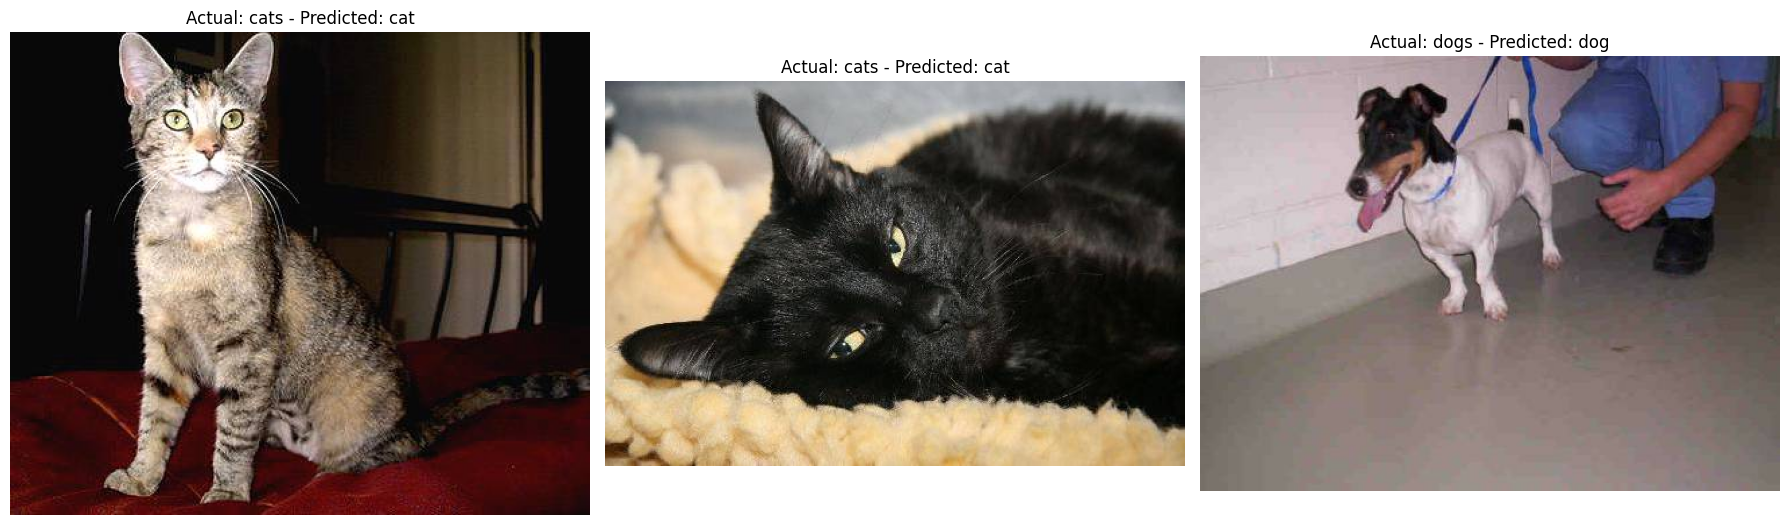

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
import numpy as np

class_mapping = {'cat':0, 'dog':1}

# model = model(input_size=224)
model_2.eval()

images = ['/kaggle/input/cats-and-dogs/Cats_and_Dogs/test/cats/cat.10000.jpg',
          '/kaggle/input/cats-and-dogs/Cats_and_Dogs/test/cats/cat.10027.jpg',
          '/kaggle/input/cats-and-dogs/Cats_and_Dogs/test/dogs/dog.10025.jpg']

fig, axs = plt.subplots(1, len(images), figsize=(18, 6))

for i, image_path in enumerate(images):
    image = Image.open(image_path)
    image_array = np.array(image)
    image = torch.FloatTensor(image_array).permute(2, 0, 1)
    image = image.view(1, *image.shape).cuda()

    with torch.no_grad():
        outputs = model_2(image)
        predicted_class = (outputs > 0.5).float().squeeze()

    predicted_label = [key for key, value in class_mapping.items() if value == predicted_class.item()][0]

    ax = axs[i]
    actual_label = image_path.split('/')[-2]

    ax.set_title(f'Actual: {actual_label} - Predicted: {predicted_label}')
    ax.imshow(image_array)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
print(actual_label)


dogs


In [ ]:
print(predicted_label)

dog


In this task, we will create and train a ResNet-based model from scratch to improve classification accuracy.

## Task 3(25 points)
Build and Train ResNet-based Model:

Design a ResNet-based neural network architecture, customizing the number of layers, channels, and other hyperparameters based on classification task.

Plot Loss and Accuracy

Evaluate accuracy on validation and test datasets separately.

In [ ]:
import torch
import torch.nn as nn

# Define the basic building blocks of a ResNet: Residual Block and Residual Layer
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        #TODO: you need to implement the forward function
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.flatten(start_dim=1)
        out = self.fc(out)
        return out

# Create a ResNet model
resnet = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=1).to('cuda')
# model_resnet = resnet()

In [ ]:
# Train your ResNet Model
import torch.optim as optim
from torch.autograd import Variable

criterion_resnet = nn.BCELoss()
optimizer_resnet = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

train_loss_resnet = []  # Initialize as an empty NumPy array
train_acc_resnet = []
val_loss_resnet = []
val_accuracy_resnet = []

# train_loss_resnet = np.append(train_loss_resnet, resnet_loss)

def train_resnet(model, no_of_epochs):
      for epoch in range(no_of_epochs):  # loop over the dataset multiple times
          resnet_loss = 0.0
          resnet_corrects = 0
          r_count = 0
          model.train()
          for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
#             inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            inputs = inputs.float()
            labels = labels.float().cuda()
            inputs = (inputs.float() / 255.0).cuda()
            optimizer_resnet.zero_grad()
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
              # TODO: calculate the preds
            binary_predictions = (outputs > 0.5).float()
            preds = binary_predictions.squeeze()
            loss = criterion_resnet(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer_resnet.step()

              # print statistics
            resnet_loss += loss.item()
            resnet_corrects += torch.sum(preds == labels.data)
            r_count += len(preds)
          resnet_loss = resnet_loss/len(train_dataloader)
          train_accuracy = resnet_corrects/r_count

          #validation
          model.eval()
          resnet_loss_val = 0.0
          resnet_corrects_val = 0
          r_count_val = 0

          with torch.no_grad():
                for i, data in enumerate(val_dataloader, 0):
                    inputs, labels = data
            #         inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    inputs = inputs.float()
                    labels = labels.float().cuda()
                    inputs = (inputs.float() / 255.0).cuda()
                    outputs = model(inputs)
                    outputs = torch.sigmoid(outputs)
                    binary_predictions = (outputs > 0.5).float()
                    preds = binary_predictions.squeeze()
                    loss = criterion_resnet(outputs.squeeze(), labels.float())

                    resnet_loss_val += loss.item()
                    resnet_corrects_val += torch.sum(preds == labels.data)
                    r_count_val += len(preds)
          resnet_loss_val = resnet_loss_val/len(val_dataloader)
          val_accuracy = resnet_corrects_val/r_count_val
#           print('Validation Data:')
          print(f"Epoch [{epoch+1}/{no_of_epochs}]: Train Loss: {resnet_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Loss: {resnet_loss_val:.4f}, Val Accuracy: {val_accuracy:.4f}")
          train_loss_resnet.append(resnet_loss)
          train_acc_resnet.append(train_accuracy)
          val_loss_resnet.append(resnet_loss_val)
          val_accuracy_resnet.append(val_accuracy)
#                   print("Training Data:")
#                   print(f"Epoch [{epoch+1}/{no_of_epochs}] : Train Loss: {resnet_loss:.4f},  Train Accuracy: {train_accuracy:.4f}")




In [ ]:
def test_resnet(model):
  model.eval()
  running_corrects_test = 0
  count_test = 0

  with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
      inputs, labels = data
#       inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      inputs = inputs.float()
      labels = labels.float().cuda()
      inputs = (inputs.float() / 255.0).cuda()
      outputs = model(inputs)
      outputs = torch.sigmoid(outputs)
      binary_predictions = (outputs > 0.5).float()
      preds = binary_predictions.squeeze()
      running_corrects_test += torch.sum(preds == labels.data)
      count_test += len(preds)
  test_accuracy = running_corrects_test/count_test
  print('Testing Data:')
  print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
train_resnet(resnet,10)

Epoch [1/10]: Train Loss: 0.6692,  Train Accuracy: 0.6093, Val Loss: 0.5950, Val Accuracy: 0.6984
Epoch [2/10]: Train Loss: 0.5597,  Train Accuracy: 0.7120, Val Loss: 0.4715, Val Accuracy: 0.7904
Epoch [3/10]: Train Loss: 0.4146,  Train Accuracy: 0.8094, Val Loss: 0.4676, Val Accuracy: 0.7679
Epoch [4/10]: Train Loss: 0.3130,  Train Accuracy: 0.8632, Val Loss: 0.4674, Val Accuracy: 0.7932
Epoch [5/10]: Train Loss: 0.2506,  Train Accuracy: 0.8962, Val Loss: 0.2518, Val Accuracy: 0.8992
Epoch [6/10]: Train Loss: 0.2039,  Train Accuracy: 0.9135, Val Loss: 0.2243, Val Accuracy: 0.9060
Epoch [7/10]: Train Loss: 0.1683,  Train Accuracy: 0.9316, Val Loss: 0.2294, Val Accuracy: 0.9040
Epoch [8/10]: Train Loss: 0.1331,  Train Accuracy: 0.9459, Val Loss: 0.2469, Val Accuracy: 0.9056
Epoch [9/10]: Train Loss: 0.1058,  Train Accuracy: 0.9571, Val Loss: 0.2372, Val Accuracy: 0.9104
Epoch [10/10]: Train Loss: 0.0739,  Train Accuracy: 0.9723, Val Loss: 0.2735, Val Accuracy: 0.9008


In [ ]:
test_resnet(resnet)

Testing Data:
Test Accuracy: 0.8920


In [ ]:
model_path_5 = 'model3.pt'
torch.save(resnet.state_dict(), model_path_5)

In [ ]:
model_path_6 = 'model3.pickle'
torch.save(resnet, model_path_6)

In [ ]:
train_loss_resnet

[0.6692224442243576,
 0.5597368677720428,
 0.414597756312415,
 0.3129730661937036,
 0.25062709534124006,
 0.2038849319790723,
 0.1683053781370516,
 0.13309386188972275,
 0.1058000543046568,
 0.07391235823560746]

In [ ]:
train_acc_resnet

[tensor(0.6093, device='cuda:0'),
 tensor(0.7120, device='cuda:0'),
 tensor(0.8094, device='cuda:0'),
 tensor(0.8632, device='cuda:0'),
 tensor(0.8962, device='cuda:0'),
 tensor(0.9135, device='cuda:0'),
 tensor(0.9316, device='cuda:0'),
 tensor(0.9459, device='cuda:0'),
 tensor(0.9571, device='cuda:0'),
 tensor(0.9723, device='cuda:0')]

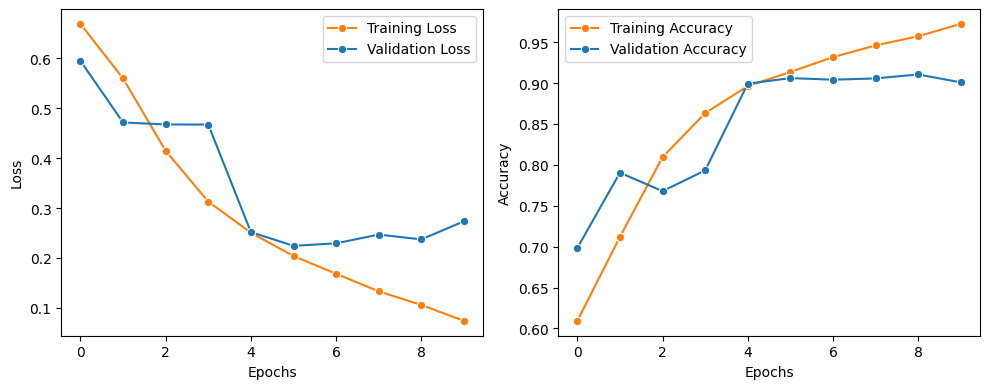

In [ ]:
# Plot loss and accuracy
fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# train_loss_values = [acc.item() for acc in train_loss_resnet]
# val_loss_values = [acc.item() for acc in val_loss_resnet]
train_acc_values = [acc.item() for acc in train_acc_resnet]
val_acc_values = [acc.item() for acc in val_accuracy_resnet]

# Plot the data in each subplot using seaborn
sns.lineplot(train_loss_resnet, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss_resnet, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_acc_values, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc_values, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In this task, we will create and train a UNet-based model from scratch to improve classification accuracy.

## Task 4(25 points)
Build and Train UNet-based Model for binary classification task:

Design a UNet-based neural network architecture, customizing the encoder,bottleneck, and the decoder structure.

Plot Loss and Accuracy

Evaluate accuracy on test datasets.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

# Define the basic building blocks: Encoder Block,Bottleneck Block, Decoder Block

class EncoderBlock(nn.Module):
    #each encoder uses 2 3*3 conv layers followed by relu and 2*2 maxpool
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool(out)
        return out

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        return out

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, bridge):
#         print("x shape:", x.shape)
#         print("bridge shape:", bridge.shape)
        out = self.convTrans(x)
        out = nn.Upsample(size=bridge.size()[2:], mode='bilinear', align_corners=False)(out)
        # Crop x to match the size of bridge
#         print("convTrans shape:", out.shape)
        out = torch.cat([out, bridge], dim=1)
#         print("concatenated shape:", out.shape)
        out = self.conv1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
#         out = self.convTrans(out)
        return out


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        # in unet we have 4 encoder blocks and 4 decoder blocks connects through bottleneck
        self.encoder = nn.Sequential(
            EncoderBlock(in_channels,64),
            EncoderBlock(64,128),
            EncoderBlock(128,256),
            EncoderBlock(256,512)
        )

        # Bottleneck
        self.bottleneck = BottleneckBlock(512,1024)

        # Decoder
        self.decoder = nn.Sequential(
            DecoderBlock(1024, 512),
            DecoderBlock(512, 256),
            DecoderBlock(256, 128),
            DecoderBlock(128, 64)
        )

        self.last_layer = nn.Conv2d(64, out_channels, kernel_size=1)


    # we have 4 encoder and 4 decoder blocks
    def forward(self, x):
        #intially. we pass i/p to encoder blocks one by one, the o/p is passed as i/p for next block
#         out1 = self.encoder[0](x)
#         out2 = self.encoder[1](out1)
#         out3 = self.encoder[2](out2)
#         out4 = self.encoder[3](out3)

        encoder_list = []
        for encoders in self.encoder:
            x = encoders(x)
            encoder_list.append(x)

        #encoder to bottleneck
#         out5 = self.bottleneck(out4)
        out = self.bottleneck(encoder_list[-1])

        #lly, decoder as encoder but the last encoder passes to intial decoder with a bottleneck
#         out6 = self.decoder[0](out5,out4)
#         out7 = self.decoder[1](out6,out3)
#         out8 = self.decoder[2](out7,out2)
#         out9 = self.decoder[3](out8,out1)
        decoder_list = list(reversed(encoder_list))
        for i, decoders in enumerate(self.decoder):
            out = decoders(out, (decoder_list)[i])

        out = self.last_layer(out)

        # global average pooling and reshaping into a 2D feature vecto
        out = out.mean(dim=[2, 3]).view(out.size(0), -1)
        out = out.squeeze()

        return out

# Create a U-Net model for binary classification
unet = UNet(3,1)
# image = torch.rand((128,128,3))
# unet(image)
unet = unet.cuda()

# Define Binary Cross-Entropy loss and an optimizer
criterion_unet = nn.BCELoss()
optimizer_unet = optim.Adam(unet.parameters(), lr=0.0001)
# scheduler_unet = StepLR(optimizer_unet, step_size=10, gamma=0.1)

In [ ]:
#Define the model training process
train_loss_unet = []
train_acc_unet = []
val_loss_unet = []
val_accuracy_unet = []

def train_unet(model, no_of_epochs):
      for epoch in range(no_of_epochs):  # loop over the dataset multiple times
          unet_loss = 0.0
          unet_corrects = 0
          unet_count = 0
          model.train()
          for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda().float()), Variable(labels.cuda().float())
            optimizer_unet.zero_grad()
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            binary_predictions = (outputs > 0.5)
            preds = binary_predictions.squeeze()
            loss = criterion_unet(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer_unet.step()
#             scheduler_unet.step()

              # print statistics
            unet_loss += loss.item()
            unet_corrects += torch.sum(preds == labels.data)
            unet_count += len(preds)
          unet_loss = unet_loss/len(train_dataloader)
          train_accuracy = unet_corrects/unet_count

          #validation
          model.eval()
          unet_loss_val = 0.0
          unet_corrects_val = 0
          unet_count_val = 0
          with torch.no_grad():
                for i, data in enumerate(val_dataloader, 0):
                    inputs, labels = data
                    inputs, labels = Variable(inputs.cuda().float()), Variable(labels.cuda().float())
            #         inputs = inputs.float()
            #         labels = labels.float().cuda()
            #         inputs = (inputs.float() / 255.0).cuda()
                    outputs = model(inputs)
                    outputs = torch.sigmoid(outputs)
                    binary_predictions = (outputs > 0.5).float()
                    preds = binary_predictions.squeeze()
                    loss = criterion_unet(outputs.squeeze(), labels.float())

                    unet_loss_val += loss.item()
                    unet_corrects_val += torch.sum(preds == labels.data)
                    unet_count_val += len(preds)
          unet_loss_val = unet_loss_val/len(val_dataloader)
          val_accuracy = unet_corrects_val/unet_count_val
#           print('Validation Data:')
          print(f"Epoch [{epoch+1}/{no_of_epochs}]:Train Loss: {unet_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Loss: {unet_loss_val:.4f}, Val Accuracy: {val_accuracy:.4f}")
#           print("Training Data:")
#           print(f"Epoch [{epoch+1}/{no_of_epochs}] : Train Loss: {unet_loss:.4f},  Train Accuracy: {train_accuracy:.4f}")

          train_loss_unet.append(unet_loss)
          train_acc_unet.append(train_accuracy)
          val_loss_unet.append(unet_loss_val)
          val_accuracy_unet.append(val_accuracy)


In [ ]:
train_unet(unet,10)

Epoch [1/10]:Train Loss: 0.6286,  Train Accuracy: 0.6382, Val Loss: 0.6178, Val Accuracy: 0.6490
Epoch [2/10]:Train Loss: 0.5859,  Train Accuracy: 0.6856, Val Loss: 0.5454, Val Accuracy: 0.7205
Epoch [3/10]:Train Loss: 0.5341,  Train Accuracy: 0.7312, Val Loss: 0.5000, Val Accuracy: 0.7566
Epoch [4/10]:Train Loss: 0.4610,  Train Accuracy: 0.7865, Val Loss: 0.4177, Val Accuracy: 0.8265
Epoch [5/10]:Train Loss: 0.3728,  Train Accuracy: 0.8370, Val Loss: 0.3890, Val Accuracy: 0.8297
Epoch [6/10]:Train Loss: 0.3029,  Train Accuracy: 0.8705, Val Loss: 0.2751, Val Accuracy: 0.8892
Epoch [7/10]:Train Loss: 0.2423,  Train Accuracy: 0.9011, Val Loss: 0.2571, Val Accuracy: 0.8888
Epoch [8/10]:Train Loss: 0.2018,  Train Accuracy: 0.9179, Val Loss: 0.2003, Val Accuracy: 0.9205
Epoch [9/10]:Train Loss: 0.1701,  Train Accuracy: 0.9310, Val Loss: 0.2212, Val Accuracy: 0.9173
Epoch [10/10]:Train Loss: 0.1396,  Train Accuracy: 0.9446, Val Loss: 0.2189, Val Accuracy: 0.9153


In [ ]:
def test_unet(model):
  model.eval()
  running_corrects_test = 0
  count_test = 0

  with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
      inputs, labels = data
      inputs, labels = Variable(inputs.cuda().float()), Variable(labels.cuda().float())
      outputs = model(inputs)
      outputs = torch.sigmoid(outputs)
      binary_predictions = (outputs > 0.5).float()
      preds = binary_predictions.squeeze()
      running_corrects_test += torch.sum(preds == labels.data)
      count_test += len(preds)
  test_accuracy = running_corrects_test/count_test
  print('Testing Data:')
  print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
test_unet(unet)

Testing Data:
Test Accuracy: 0.9184


In [ ]:
model_path_7 = 'model4.pt'
torch.save(unet.state_dict(), model_path_7)

In [ ]:
model_path_8 = 'model4.pickle'
torch.save(unet, model_path_8)

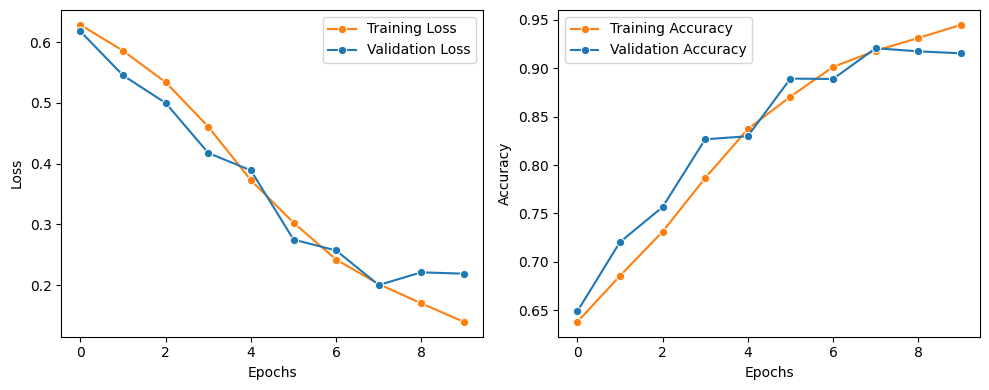

In [ ]:
#Plot Loss and Accuracy
# Plot loss and accuracy
fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# train_loss_values = [acc.item() for acc in train_loss_resnet]
# val_loss_values = [acc.item() for acc in val_loss_resnet]
train_acc_m = [acc.item() for acc in train_acc_unet]
val_acc_m = [acc.item() for acc in val_accuracy_unet]

# Plot the data in each subplot using seaborn
sns.lineplot(train_loss_unet, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss_unet, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_acc_m, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc_m, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#Evaluate accuracy on test datasets.

References:

1. https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201
2. https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
3. https://pytorch.org/tutorials/beginner/introyt/trainingyt.html